<a href="https://colab.research.google.com/github/egonloch/DNC/blob/main/Desafio_6_Egon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1421]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Target**: Churned

Variáveis do problema

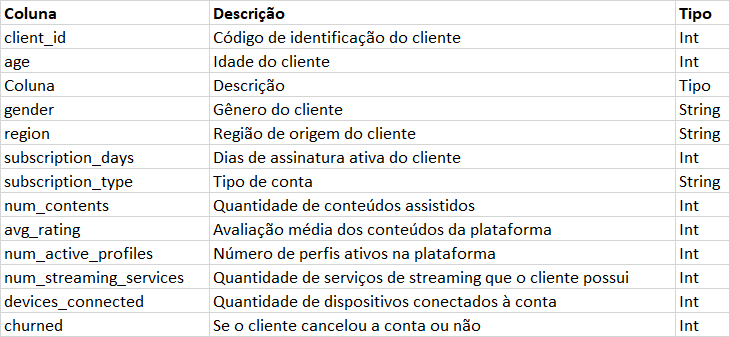

In [1422]:
#upload do arquivo
churn = pd.read_csv("/content/streaming_data.csv")
#apresentação dos dados
churn.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


# Data Understanding

In [1423]:
#descrição dos dados
churn.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


In [1424]:
#procurar valores nulos nos dados
valores_nulos_totais = churn.isnull().sum()
print("Valores nulos totais no DataFrame:")
print(valores_nulos_totais)

Valores nulos totais no DataFrame:
Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64


In [1425]:
#Substituir valores “NaN” por 0 Colunas → Time_on_platform,
#Num_streaming_services, Churned, Avg_rating, Devices_connected
churn['Time_on_platform'].fillna(0, inplace=True)
churn['Devices_connected'].fillna(0, inplace=True)
churn['Avg_rating'].fillna(0, inplace=True)
churn['Churned'].fillna(0, inplace=True)
churn['Num_streaming_services'].fillna(0, inplace=True)

In [1426]:
#Dropar linhas nulas nas colunas Gender, Subscription_type e Age
churn.dropna(subset=['Age', 'Gender', 'Subscription_type'], inplace=True)

In [1427]:
#verificando a existencia ainda de valores nulos
valores_nulos_totais = churn.isnull().sum()
print("Valores nulos totais no DataFrame:")
print(valores_nulos_totais)

Valores nulos totais no DataFrame:
Age                       0
Gender                    0
Time_on_platform          0
Devices_connected         0
Subscription_type         0
Num_streaming_services    0
Num_active_profiles       0
Avg_rating                0
Churned                   0
User_id                   0
dtype: int64


In [1428]:
#Informações dos dados
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36515 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     36515 non-null  float64
 1   Gender                  36515 non-null  object 
 2   Time_on_platform        36515 non-null  float64
 3   Devices_connected       36515 non-null  float64
 4   Subscription_type       36515 non-null  object 
 5   Num_streaming_services  36515 non-null  float64
 6   Num_active_profiles     36515 non-null  int64  
 7   Avg_rating              36515 non-null  float64
 8   Churned                 36515 non-null  float64
 9   User_id                 36515 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


In [1429]:
#Transformando valores floats em valores inteiros
churn['Age'] = churn['Age'].astype(int)
churn['Devices_connected'] = churn['Devices_connected'].astype(int)
churn['Num_active_profiles'] = churn['Num_active_profiles'].astype(int)
churn['Avg_rating'] = churn['Avg_rating'].astype(int)
churn['Time_on_platform'] = churn['Time_on_platform'].astype(int)

In [1430]:
# Transformando valores churned 0 e 1 por No e Yes
churn['Churned'] = churn['Churned'].map({0: 'Não', 1: 'Sim'})

In [1431]:
#Número de usarios churned
churn_agg = churn.groupby("Churned")['User_id'].count().reset_index()
churn_agg = pd.DataFrame(churn_agg)
churn_agg

,Churned,User_id
0,Não,29459
1,Sim,7056


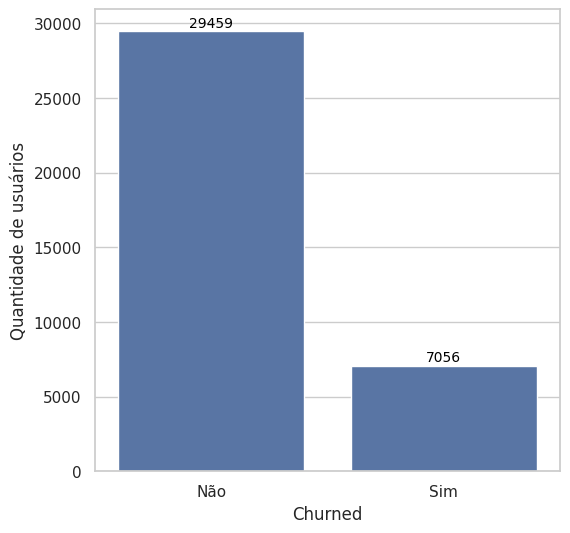

In [1432]:
#Grafico de usarios churned
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

ax = sns.barplot(data=churn_agg, x="Churned", y="User_id")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 6),
                textcoords='offset points')

plt.xlabel("Churned")
plt.ylabel("Quantidade de usuários")

plt.show()

In [1433]:
#Classificação por tipo assinatura
churn_agg = churn.groupby("Subscription_type")['User_id'].count().reset_index()
churn_agg = pd.DataFrame(churn_agg)
churn_agg

,Subscription_type,User_id
0,Basic,12134
1,Premium,12224
2,Standard,12157


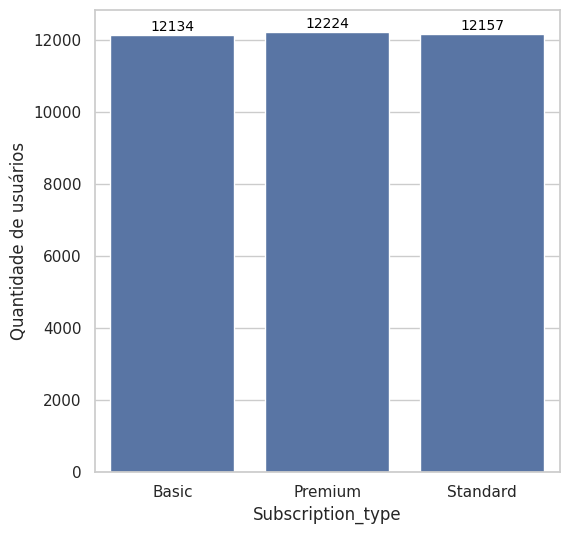

In [1434]:
#Grafico por tipo de assinatura
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

ax = sns.barplot(data=churn_agg, x="Subscription_type", y="User_id")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 6),
                textcoords='offset points')

plt.xlabel("Subscription_type")
plt.ylabel("Quantidade de usuários")

plt.show()

In [1435]:
#Classificaçao por assinatura
churn_agg_gender = churn.groupby("Gender")['User_id'].count().reset_index()
churn_agg_gender = pd.DataFrame(churn_agg_gender)
churn_agg_gender

,Gender,User_id
0,Female,18149
1,Male,18366


# Preparação para modelagens

In [1436]:
churn.dtypes

Age                         int64
Gender                     object
Time_on_platform            int64
Devices_connected           int64
Subscription_type          object
Num_streaming_services    float64
Num_active_profiles         int64
Avg_rating                  int64
Churned                    object
User_id                    object
dtype: object

In [1437]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(churn.Churned)
churn.Churned = le.transform(churn.Churned)

In [1438]:
X = churn.drop(['User_id', 'Churned'], axis=1)

y = churn[['Churned']]

In [1439]:
X = pd.get_dummies(X)

In [1440]:
# Import the necessary sklearn method
from sklearn.preprocessing import MinMaxScaler
# Instantiate a Min-Max scaling object
mm = MinMaxScaler()
# Fit and transform our feature data into a pandas dataframe
X = pd.DataFrame(mm.fit_transform(X))

In [1441]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [1442]:
y_train = y_train['Churned'].to_numpy().ravel()
y_test = y_test['Churned'].to_numpy().ravel()

# Regressão Logística

In [1443]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
lr = model.fit(X_train, y_train)

In [1444]:
lr.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [1445]:
X_test.assign(churn = y_test).assign(label = lr.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,10,churn,label
12726,0.176471,0.000000,0.6,0.0,0.00,0.0,1.0,0.0,0.0,0.0,1.0,0,0
30718,0.176471,0.249344,0.2,0.0,0.75,0.0,0.0,1.0,0.0,0.0,1.0,0,0
31415,0.686275,0.420824,0.2,0.5,0.00,0.6,1.0,0.0,0.0,0.0,1.0,0,0
20860,0.862745,0.000000,0.0,0.0,0.75,0.0,1.0,0.0,0.0,1.0,0.0,1,0
19287,0.039216,0.206645,0.2,0.0,0.00,0.6,1.0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,0.058824,0.448339,0.6,1.0,0.50,0.4,0.0,1.0,0.0,1.0,0.0,0,0
3113,0.803922,0.708643,0.0,0.0,1.00,0.2,0.0,1.0,0.0,0.0,1.0,0,0
34929,0.823529,0.166686,0.4,0.0,0.25,0.2,1.0,0.0,0.0,0.0,1.0,0,0
27995,0.137255,0.985729,0.0,0.0,0.00,0.2,0.0,1.0,1.0,0.0,0.0,1,0


--------------------Previsão-----------------



Text(0.5, 1.0, 'Projetado')

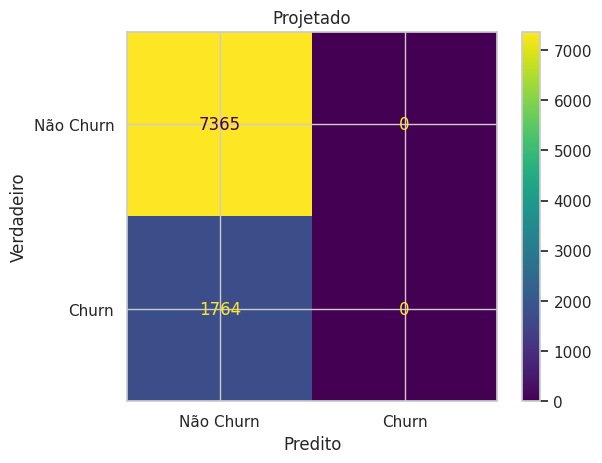

In [1446]:
print('--------------------Previsão-----------------\n')
y_pred = lr.predict(X_test)

#Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Churn', 'Churn']).plot()
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Projetado')

In [1447]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(f"Acurácia (Treino): {accuracy_score(y_train, lr.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, lr.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, lr.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, lr.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, lr.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, lr.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.8067625794201416
Acurácia (Teste): 0.8067696352283931
Acurácia Balanceada (Treino): 0.5
Acurácia Balanceada (Teste): 0.5
Precision (Treino): 0.0
Precision (Teste): 0.0
Recall (Treino): 0.0
Recall (Teste): 0.0
F1-Score (Treino): 0.0
F1-Score (Teste): 0.0
ROCAUC (Treino): 0.511308241752189
ROCAUC (Teste): 0.5026293001925821


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest


In [1537]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

In [1538]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [1539]:
rf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [1540]:
X_test.assign(churn = y_test).assign(label = rf.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,10,churn,label
12726,0.176471,0.000000,0.6,0.0,0.00,0.0,1.0,0.0,0.0,0.0,1.0,0,0
30718,0.176471,0.249344,0.2,0.0,0.75,0.0,0.0,1.0,0.0,0.0,1.0,0,0
31415,0.686275,0.420824,0.2,0.5,0.00,0.6,1.0,0.0,0.0,0.0,1.0,0,0
20860,0.862745,0.000000,0.0,0.0,0.75,0.0,1.0,0.0,0.0,1.0,0.0,1,1
19287,0.039216,0.206645,0.2,0.0,0.00,0.6,1.0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,0.058824,0.448339,0.6,1.0,0.50,0.4,0.0,1.0,0.0,1.0,0.0,0,0
3113,0.803922,0.708643,0.0,0.0,1.00,0.2,0.0,1.0,0.0,0.0,1.0,0,0
34929,0.823529,0.166686,0.4,0.0,0.25,0.2,1.0,0.0,0.0,0.0,1.0,0,0
27995,0.137255,0.985729,0.0,0.0,0.00,0.2,0.0,1.0,1.0,0.0,0.0,1,0


--------------------Previsão-----------------



Text(0.5, 1.0, 'Projetado')

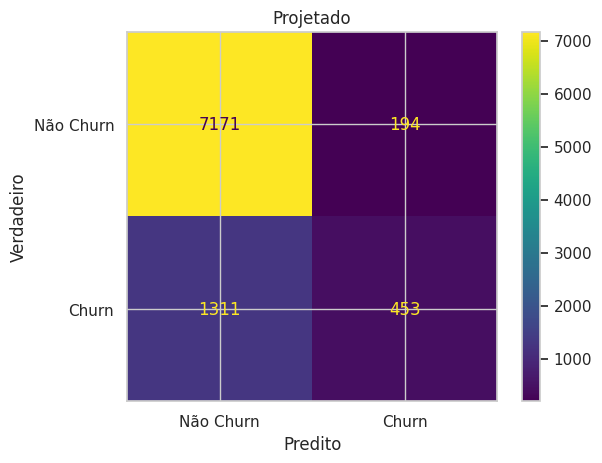

In [1541]:
print('--------------------Previsão-----------------\n')
y_pred = rf.predict(X_test)

#Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Churn', 'Churn']).plot()
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Projetado')

In [1542]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(f"Acurácia (Treino): {accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.995180018987804
Acurácia (Teste): 0.8351407602147004
Acurácia Balanceada (Treino): 0.9898994494149611
Acurácia Balanceada (Teste): 0.6152309600011083
Precision (Treino): 0.9936854190585533
Precision (Teste): 0.7001545595054096
Recall (Treino): 0.9812925170068028
Recall (Teste): 0.2568027210884354
F1-Score (Treino): 0.9874500855675984
F1-Score (Teste): 0.3757776856076317
ROCAUC (Treino): 0.9997942806866368
ROCAUC (Teste): 0.6773870715971385


# Tunning

In [1522]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [1, 5, 10],
    'n_estimators': [100, 300],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None]
    }

grid_search = GridSearchCV(rf, parameters, scoring='accuracy', cv=5, n_jobs=-1)

In [1523]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=5, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 5, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 300]},
             scoring='accuracy')

In [1524]:
dict = grid_search.best_estimator_.get_params()

In [1525]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [1536]:
#mudei para balanced pq os valores não estavam muito precisos
from sklearn.ensemble import RandomForestClassifier

rf_tunned =  RandomForestClassifier(bootstrap = True, ccp_alpha = 0.0,
                                     class_weight = 'balanced', criterion= 'gini',
                                     max_depth = 10, max_features= 'sqrt',
                                     max_leaf_nodes = None,
                                     max_samples = None,
                                     min_impurity_decrease = 0.0,
                                     min_samples_leaf = 1,
                                     min_samples_split = 2,
                                     min_weight_fraction_leaf = 0.0,
                                     n_estimators = 300, n_jobs = None,
                                     oob_score = False, random_state = 42,
                                     verbose = 0, warm_start = False)
rf_tunned

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300,
                       random_state=42)

In [1532]:
rf_tunned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300,
                       random_state=42)

In [1533]:
rf_tunned.predict(X_test)

array([0, 0, 0, ..., 0, 0, 1])

In [1534]:
X_test.assign(churn = y_test).assign(label = rf_tunned.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,10,churn,label
12726,0.176471,0.000000,0.6,0.0,0.00,0.0,1.0,0.0,0.0,0.0,1.0,0,0
30718,0.176471,0.249344,0.2,0.0,0.75,0.0,0.0,1.0,0.0,0.0,1.0,0,0
31415,0.686275,0.420824,0.2,0.5,0.00,0.6,1.0,0.0,0.0,0.0,1.0,0,0
20860,0.862745,0.000000,0.0,0.0,0.75,0.0,1.0,0.0,0.0,1.0,0.0,1,1
19287,0.039216,0.206645,0.2,0.0,0.00,0.6,1.0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,0.058824,0.448339,0.6,1.0,0.50,0.4,0.0,1.0,0.0,1.0,0.0,0,0
3113,0.803922,0.708643,0.0,0.0,1.00,0.2,0.0,1.0,0.0,0.0,1.0,0,1
34929,0.823529,0.166686,0.4,0.0,0.25,0.2,1.0,0.0,0.0,0.0,1.0,0,0
27995,0.137255,0.985729,0.0,0.0,0.00,0.2,0.0,1.0,1.0,0.0,0.0,1,0


In [1535]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(f"Acurácia (Treino): {accuracy_score(y_train, rf_tunned.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf_tunned.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf_tunned.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf_tunned.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf_tunned.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf_tunned.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf_tunned.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.834769590301614
Acurácia (Teste): 0.7264760652864498
Acurácia Balanceada (Treino): 0.7749458508245639
Acurácia Balanceada (Teste): 0.5599566574762966
Precision (Treino): 0.5598937997813525
Precision (Teste): 0.2906910336950314
Recall (Treino): 0.677437641723356
Recall (Teste): 0.2885487528344671
F1-Score (Treino): 0.6130825138948267
F1-Score (Teste): 0.28961593172119493
ROCAUC (Treino): 0.8815435385302447
ROCAUC (Teste): 0.5819513911018129


**Resultados antes do tuning:**

Recall no conjunto de teste: 0.253 (aproximadamente 25.3%)

F1-Score no conjunto de teste: 0.371 (aproximadamente 37.1%)


**Resultados após o tuning:**

Recall no conjunto de teste: 0.000566 (aproximadamente 0.06%)

F1-Score no conjunto de teste: 0.00113 (aproximadamente 0.11%)


---
\
Essa melhoria sugere que o ajuste de hiperparâmetros foi eficaz em melhorar a capacidade do modelo de identificar instâncias positivas (Churn)